## Import standard packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from datetime import datetime

import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

# import warnings
# from sklearn.utils.testing import ignore_warnings
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings('ignore')

In [2]:
url = 'https://drive.google.com/file/d/1HfTP590blvZIYS3MhlQyZK3or4lgIGaV/view'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url)
data.head()
# data = pd.read_csv("/content/Zip_zhvi_bdrmcnt_3_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
# data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,96603.0,...,232376.0,236021.0,239693.0,244103.0,249528.0,255561.0,261406.0,266140.0,269363.0,271087.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,163540.0,...,330128.0,334969.0,339733.0,346806.0,355476.0,365971.0,374539.0,379908.0,381471.0,380327.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,87170.0,...,167760.0,169442.0,171444.0,173448.0,175569.0,178832.0,182377.0,185780.0,188090.0,189856.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,324450.0,...,814606.0,815163.0,817786.0,818496.0,823195.0,827059.0,836542.0,842837.0,849412.0,852484.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,279395.0,...,749033.0,750202.0,754601.0,758353.0,764191.0,766694.0,772804.0,778368.0,783167.0,785138.0


We will drop 'StateName' and 'RegionType' due to redundancy, and 'SizeRank' due to it being irrelevant for analysis. 

In [3]:
# Drop unnecessary columns 
data = data.drop(['RegionID', 'StateName', 'RegionType', 'SizeRank'], axis=1)

# Change name of 'RegionName' to 'ZipCode'
data = data.rename(columns={'RegionName': 'ZipCode'})

In [4]:
data.isna().sum().sum()

1644543

In [5]:
data.shape

(23404, 277)

## Analyze 'ZipCode'

Next we will look at RegionName, this is the zip code.

In [6]:
data.ZipCode.value_counts() 

77449    1
35203    1
39464    1
71430    1
17505    1
        ..
25401    1
74344    1
6120     1
33301    1
50160    1
Name: ZipCode, Length: 23404, dtype: int64

All zipcodes are unique. Changing to string

In [7]:
data.ZipCode = data.ZipCode.astype('string')

In [8]:
data[['ZipCode', 'State']].sort_values(by=['ZipCode'])

,ZipCode,State
4646,10001,NY
137,10002,NY
655,10003,NY
11591,10005,NY
9650,10007,NY
...,...,...
3676,99709,AK
7046,99712,AK
4183,99801,AK
16770,99824,AK


In [9]:
data.ZipCode.count()

23404

## Analyze 'City'

In [10]:
data.City.nunique()

11311

In [11]:
data.City.isna().sum()

1085

In [12]:
data.City.fillna('None', inplace=True)

## Analyze 'Metro'

Fillna with None

In [13]:
print(data.Metro.value_counts())
print(data.Metro.nunique())

New York-Newark-Jersey City, NY-NJ-PA           793
Chicago-Naperville-Elgin, IL-IN-WI              368
Los Angeles-Long Beach-Anaheim, CA              355
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     316
Washington-Arlington-Alexandria, DC-VA-MD-WV    292
                                               ... 
Lamesa, TX                                        1
Connersville, IN                                  1
Portales, NM                                      1
Natchitoches, LA                                  1
Hereford, TX                                      1
Name: Metro, Length: 922, dtype: int64
922


In [14]:
data.Metro.fillna('None', inplace=True)

In [15]:
data.Metro.value_counts()

None                                           4206
New York-Newark-Jersey City, NY-NJ-PA           793
Chicago-Naperville-Elgin, IL-IN-WI              368
Los Angeles-Long Beach-Anaheim, CA              355
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     316
                                               ... 
Zapata, TX                                        1
Craig, CO                                         1
Clovis, NM                                        1
Butte-Silver Bow, MT                              1
Natchitoches, LA                                  1
Name: Metro, Length: 923, dtype: int64

## Analyze 'CountyName'

In [16]:
data.CountyName.value_counts()

Washington County     275
Los Angeles County    268
Jefferson County      260
Montgomery County     215
Franklin County       201
                     ... 
Lanier County           1
Catahoula Parish        1
Brewster County         1
Early County            1
McCone County           1
Name: CountyName, Length: 1705, dtype: int64

In [17]:
data.isna().sum()

ZipCode         0
State           0
City            0
Metro           0
CountyName      0
             ... 
2022-04-30    279
2022-05-31    238
2022-06-30    157
2022-07-31     85
2022-08-31     12
Length: 277, dtype: int64

In [18]:
data.CountyName.fillna('None', inplace=True)

## Drop sales data that have missing values

In [19]:
data[data['2000-01-31'].isna()]

,ZipCode,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
29,94565,CA,Pittsburg,"San Francisco-Oakland-Berkeley, CA",Contra Costa County,NaN,NaN,NaN,NaN,NaN,...,563088.0,568049.0,578143.0,584834.0,594957.0,602028.0,602774.0,597243.0,589975.0,584882.0
32,78521,TX,Brownsville,"Brownsville-Harlingen, TX",Cameron County,NaN,NaN,NaN,NaN,NaN,...,141332.0,143702.0,145785.0,148925.0,151875.0,155071.0,157557.0,160752.0,163829.0,167074.0
41,10456,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Bronx County,NaN,NaN,NaN,NaN,NaN,...,458589.0,463623.0,470458.0,474277.0,475801.0,478393.0,480640.0,484812.0,484884.0,488002.0
44,11219,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,NaN,NaN,NaN,NaN,NaN,...,829604.0,828789.0,828065.0,830625.0,836662.0,843739.0,849336.0,853506.0,857684.0,864057.0
50,77573,TX,League City,"Houston-The Woodlands-Sugar Land, TX",Galveston County,NaN,NaN,NaN,NaN,NaN,...,290825.0,294876.0,297864.0,301136.0,305735.0,312295.0,317528.0,320674.0,321755.0,323265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23399,46799,IN,Zanesville,"Bluffton, IN",Wells County,NaN,NaN,NaN,NaN,NaN,...,157257.0,160065.0,162584.0,165641.0,166776.0,168208.0,169037.0,170919.0,172515.0,174173.0
23400,77451,TX,East Bernard,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,211125.0,211719.0,210235.0,205233.0
23401,14441,NY,Dresden,"Rochester, NY",Yates County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147462.0,149161.0
23402,26576,WV,Farmington,"Fairmont, WV",Marion County,NaN,NaN,NaN,NaN,NaN,...,86012.0,87789.0,89386.0,91390.0,91966.0,93260.0,94337.0,95119.0,95557.0,95880.0


In [20]:
# All zipcodes have some data
data[data['2022-06-30'].isna()]

,ZipCode,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
1057,11237,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1133842.0
5727,37857,TN,Rogersville,"Kingsport-Bristol, TN-VA",Hawkins County,73133.0,73542.0,73512.0,73770.0,73636.0,...,152657.0,155458.0,157304.0,160452.0,162559.0,166128.0,171648.0,NaN,186733.0,192806.0
8071,74003,OK,Bartlesville,"Bartlesville, OK",Washington County,49969.0,49995.0,50338.0,50749.0,51328.0,...,95618.0,97502.0,99215.0,101107.0,102623.0,104657.0,106346.0,NaN,103021.0,101139.0
10647,62201,IL,East Saint Louis,"St. Louis, MO-IL",Saint Clair County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65833.0,67697.0
11097,28128,NC,Norwood,"Albemarle, NC",Stanly County,150767.0,151217.0,151680.0,152798.0,153793.0,...,282503.0,286983.0,291784.0,296154.0,298957.0,NaN,NaN,NaN,NaN,230328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23391,45032,OH,Harveysburg,"Cincinnati, OH-KY-IN",Warren County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200021.0
23393,95419,CA,Camp Meeker,"Santa Rosa-Petaluma, CA",Sonoma County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,633246.0,620842.0
23396,98628,WA,Goldendale,None,Klickitat County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139024.0,140818.0
23397,98522,WA,Chehalis,"Centralia, WA",Lewis County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,572066.0,574933.0


In [21]:
def melt_data(data):
    melted = pd.melt(data,
                     id_vars=['ZipCode', 'State', 'City', 'Metro', 'CountyName'],
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [22]:
melted_data = melt_data(data)
melted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4726636 entries, 0 to 6365887
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ZipCode     string        
 1   State       object        
 2   City        object        
 3   Metro       object        
 4   CountyName  object        
 5   Date        datetime64[ns]
 6   value       float64       
dtypes: datetime64[ns](1), float64(1), object(4), string(1)
memory usage: 288.5+ MB


In [23]:
# Make sure the data type of the 'Date' column is datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%Y/%m')

# Set the 'Date' columns as index
melted_data.set_index('Date', inplace=True)

melted_data.info

<bound method DataFrame.info of            ZipCode State          City                                  Metro  \
Date                                                                            
2000-01-31   77449    TX          None   Houston-The Woodlands-Sugar Land, TX   
2000-01-31   77494    TX          None   Houston-The Woodlands-Sugar Land, TX   
2000-01-31   79936    TX       El Paso                            El Paso, TX   
2000-01-31   11368    NY      New York  New York-Newark-Jersey City, NY-NJ-PA   
2000-01-31   11385    NY      New York  New York-Newark-Jersey City, NY-NJ-PA   
...            ...   ...           ...                                    ...   
2022-08-31   46799    IN    Zanesville                           Bluffton, IN   
2022-08-31   77451    TX  East Bernard   Houston-The Woodlands-Sugar Land, TX   
2022-08-31   14441    NY       Dresden                          Rochester, NY   
2022-08-31   26576    WV    Farmington                           Fairmont, WV

In [24]:
melted_data.head()

,ZipCode,State,City,Metro,CountyName,value
Date,,,,,,
2000-01-31,77449,TX,None,"Houston-The Woodlands-Sugar Land, TX",Harris County,96603.0
2000-01-31,77494,TX,None,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,163540.0
2000-01-31,79936,TX,El Paso,"El Paso, TX",El Paso County,87170.0
2000-01-31,11368,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,324450.0
2000-01-31,11385,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,279395.0


## EDA on ZipCodes

In [25]:
print('Average home value' ,round(data['2022-08-31'].mean()))

Average home value 346470


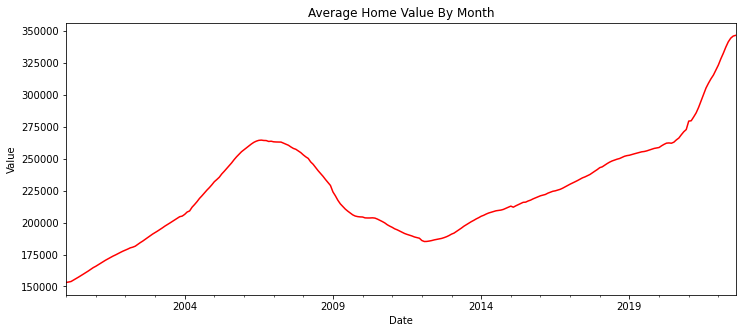

In [26]:
#Average Home Value by Month and Year
month_data = melted_data['value'].resample('MS').mean()
month_data = month_data.fillna(month_data.bfill())
month_data.plot(figsize=(12,5), color='red')
plt.title('Average Home Value By Month')
plt.ylabel('Value')
plt.show()

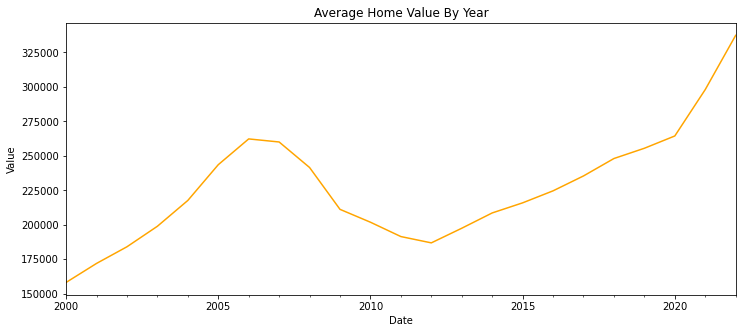

In [27]:
yr_data = melted_data['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average Home Value By Year')
plt.ylabel('Value')
plt.show()

## Top 10 Metro and County (mean)

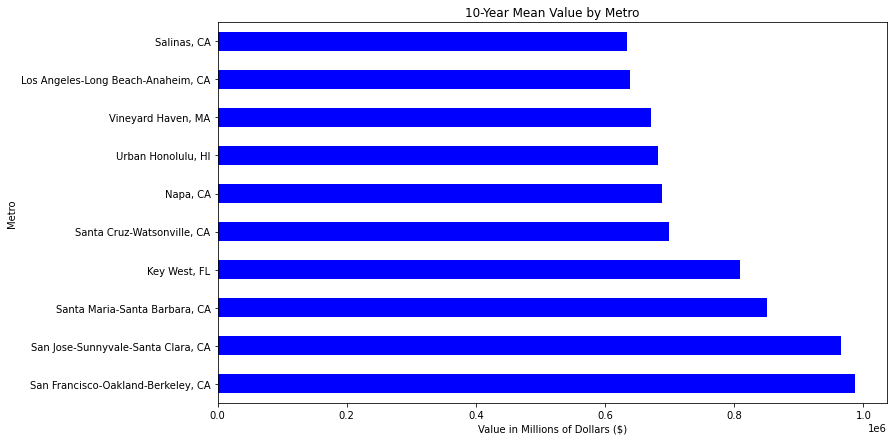

In [28]:
# Get Mean Home Value by metro
metro = melted_data.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

# Plot Mean Home Value by Metro
metro.plot.barh(figsize=(12,7), color='blue')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

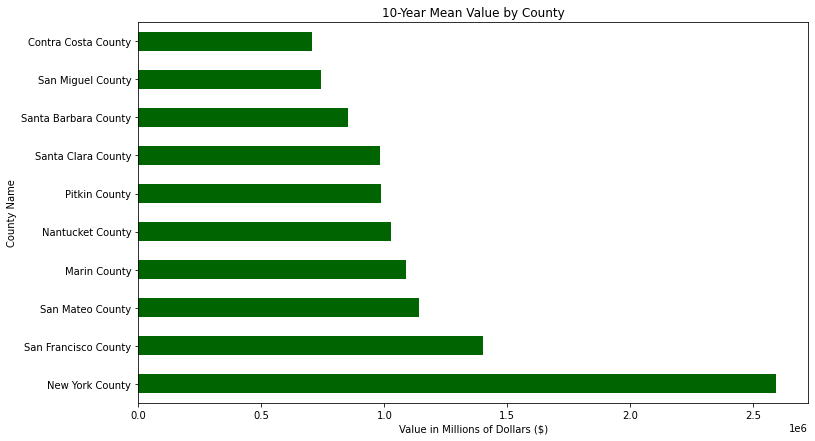

In [29]:
# Get Mean Home Value by County
county = melted_data.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

# Plot Mean Home Value by County
county.plot.barh(figsize = (12,7), color='darkgreen')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

## Most recent one year ROI

In [30]:
# Check out most recent 1 year ROI
data['recent_1_yr_ROI'] = (data['2022-08-31'] - data['2021-08-31'])/(data['2021-08-31'])
data['recent_1_yr_ROI']

0        0.232488
1        0.219513
2        0.182189
3        0.056239
4        0.063654
           ...   
23399    0.132435
23400         NaN
23401         NaN
23402    0.129528
23403    0.170195
Name: recent_1_yr_ROI, Length: 23404, dtype: float64

In [31]:
# Lowest Values
data.sort_values('recent_1_yr_ROI').head()[['ZipCode', 'City', 'recent_1_yr_ROI']]

,ZipCode,City,recent_1_yr_ROI
10302,32626,Chiefland,-0.159863
11097,28128,Norwood,-0.156950
12943,32621,Bronson,-0.155968
10441,63120,Saint Louis,-0.145128
20261,41776,Wooton,-0.143996


In [32]:
# Highest Values 
data.sort_values('recent_1_yr_ROI', ascending=False).head()[['ZipCode', 'City', 'recent_1_yr_ROI']]

,ZipCode,City,recent_1_yr_ROI
11610,44627,Fredericksburg,0.670043
10427,44606,Apple Creek,0.604589
8815,34102,Naples,0.575952
12518,44676,Shreve,0.575068
6636,34114,Naples,0.547776


In [33]:
def average_one_year_ROI(data):
    average_one_year_ROI = []
    for i in range(len(data)):
        year_1_ROI = data['recent_1_yr_ROI'][i]
        year_2_ROI = (data.iloc[i,-15] - data.iloc[i,-27])/data.iloc[i,-27]
        year_3_ROI = (data.iloc[i,-27] - data.iloc[i,-39])/data.iloc[i,-39]
        avg_ROI = (year_1_ROI + year_2_ROI + year_3_ROI)/3
        average_one_year_ROI.append(avg_ROI)
    return average_one_year_ROI   

In [34]:
data['avg_one_yr_ROI'] = average_one_year_ROI(data)

In [35]:
data_top = data[(data['2022-08-31'] < 100000) & (data['avg_one_yr_ROI'] > 0.20)]
data_top

,ZipCode,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,recent_1_yr_ROI,avg_one_yr_ROI
1067,48219,MI,Detroit,"Detroit-Warren-Dearborn, MI",Wayne County,NaN,NaN,NaN,NaN,NaN,...,77701.0,77786.0,78584.0,80394.0,82735.0,84219.0,84771.0,85091.0,0.125900,0.211613
2513,48601,MI,Saginaw,"Saginaw, MI",Saginaw County,42620.0,42675.0,42816.0,43020.0,43221.0,...,60947.0,61496.0,62242.0,63394.0,64096.0,65138.0,65767.0,66539.0,0.203999,0.217973
2879,19132,PA,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Philadelphia County,19135.0,18942.0,18983.0,19016.0,19210.0,...,85059.0,86163.0,86559.0,87697.0,88772.0,89930.0,90909.0,91530.0,0.209259,0.254554
3725,45417,OH,Dayton,"Dayton-Kettering, OH",Montgomery County,44806.0,44592.0,44609.0,44652.0,44730.0,...,63305.0,63519.0,64049.0,64184.0,64689.0,65016.0,65404.0,64722.0,0.109850,0.200708
4336,31206,GA,Macon,"Macon-Bibb County, GA",Bibb County,40164.0,40351.0,40365.0,40573.0,40701.0,...,60608.0,62110.0,63477.0,64900.0,65720.0,67165.0,68890.0,70769.0,0.289123,0.238537
4554,43605,OH,Toledo,"Toledo, OH",Lucas County,49358.0,49369.0,49693.0,49980.0,50138.0,...,46214.0,47134.0,47775.0,48393.0,48688.0,48987.0,49580.0,50093.0,0.169086,0.211947
4576,48238,MI,Detroit,"Detroit-Warren-Dearborn, MI",Wayne County,18133.0,18580.0,19135.0,20107.0,20709.0,...,50389.0,50786.0,52053.0,53544.0,55475.0,56926.0,56958.0,57141.0,0.206805,0.202534
4716,38114,TN,Memphis,"Memphis, TN-MS-AR",Shelby County,73801.0,74658.0,74989.0,75775.0,75991.0,...,79603.0,82475.0,84876.0,87368.0,89478.0,91876.0,93774.0,95504.0,0.346473,0.285365
4807,35020,AL,Bessemer,"Birmingham-Hoover, AL",Jefferson County,NaN,NaN,NaN,NaN,NaN,...,72305.0,75109.0,76528.0,76948.0,76610.0,77088.0,77235.0,78050.0,0.238869,0.222329
4967,38106,TN,Memphis,"Memphis, TN-MS-AR",Shelby County,55646.0,55686.0,55787.0,55973.0,56057.0,...,59551.0,60839.0,62233.0,63252.0,63873.0,64169.0,64862.0,64812.0,0.186403,0.232560


In [36]:
data_top[['ZipCode', 'City','State','Metro','2022-08-31','avg_one_yr_ROI']]

,ZipCode,City,State,Metro,2022-08-31,avg_one_yr_ROI
1067,48219,Detroit,MI,"Detroit-Warren-Dearborn, MI",85091.0,0.211613
2513,48601,Saginaw,MI,"Saginaw, MI",66539.0,0.217973
2879,19132,Philadelphia,PA,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",91530.0,0.254554
3725,45417,Dayton,OH,"Dayton-Kettering, OH",64722.0,0.200708
4336,31206,Macon,GA,"Macon-Bibb County, GA",70769.0,0.238537
4554,43605,Toledo,OH,"Toledo, OH",50093.0,0.211947
4576,48238,Detroit,MI,"Detroit-Warren-Dearborn, MI",57141.0,0.202534
4716,38114,Memphis,TN,"Memphis, TN-MS-AR",95504.0,0.285365
4807,35020,Bessemer,AL,"Birmingham-Hoover, AL",78050.0,0.222329
4967,38106,Memphis,TN,"Memphis, TN-MS-AR",64812.0,0.232560


In [37]:
train_df = data.iloc[:,5:275]
train_df['Y'] = data['ZipCode']
train_df = train_df.dropna()
train_df.head(15)

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,Y
0,96603.0,96618.0,96448.0,96469.0,96525.0,96681.0,96773.0,96916.0,97269.0,97495.0,...,229140.0,232376.0,236021.0,239693.0,244103.0,249528.0,255561.0,261406.0,266140.0,77449
1,163540.0,163790.0,164054.0,164736.0,164592.0,164357.0,163287.0,163089.0,162523.0,162956.0,...,324394.0,330128.0,334969.0,339733.0,346806.0,355476.0,365971.0,374539.0,379908.0,77494
2,87170.0,87231.0,87281.0,87299.0,87355.0,87358.0,87355.0,87321.0,86777.0,86149.0,...,165773.0,167760.0,169442.0,171444.0,173448.0,175569.0,178832.0,182377.0,185780.0,79936
6,133522.0,133545.0,133889.0,134658.0,135686.0,136885.0,138103.0,139448.0,140659.0,141864.0,...,244938.0,247985.0,250548.0,253484.0,255487.0,257701.0,259941.0,263459.0,265572.0,60629
7,96608.0,96564.0,96319.0,96256.0,96219.0,96379.0,96407.0,96551.0,96895.0,97217.0,...,224732.0,227606.0,230914.0,234220.0,237989.0,242657.0,247697.0,252703.0,256619.0,77084
8,144773.0,145040.0,145795.0,147167.0,148867.0,150796.0,152912.0,155104.0,156911.0,158351.0,...,653522.0,659038.0,665242.0,669849.0,677464.0,687363.0,700572.0,711423.0,712829.0,91331
9,172932.0,173000.0,173534.0,174565.0,175941.0,177514.0,179214.0,181024.0,182340.0,183331.0,...,634629.0,639038.0,644314.0,649243.0,657427.0,670768.0,687588.0,702447.0,705918.0,90650
10,154747.0,155444.0,155819.0,156901.0,158129.0,159745.0,161124.0,162771.0,164634.0,166954.0,...,469606.0,476719.0,482556.0,488499.0,496963.0,507231.0,517322.0,528628.0,538842.0,8701
12,161035.0,161091.0,161694.0,162619.0,163839.0,165026.0,166247.0,167511.0,168083.0,168583.0,...,581412.0,583078.0,585910.0,588850.0,595543.0,605271.0,618977.0,630980.0,634574.0,90201
13,108996.0,109890.0,110447.0,111717.0,112769.0,113749.0,114516.0,115124.0,115849.0,116782.0,...,488124.0,491535.0,496500.0,503139.0,511656.0,519293.0,527292.0,533159.0,538622.0,92335


In [38]:
train_df.head(15)

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,Y
0,96603.0,96618.0,96448.0,96469.0,96525.0,96681.0,96773.0,96916.0,97269.0,97495.0,...,229140.0,232376.0,236021.0,239693.0,244103.0,249528.0,255561.0,261406.0,266140.0,77449
1,163540.0,163790.0,164054.0,164736.0,164592.0,164357.0,163287.0,163089.0,162523.0,162956.0,...,324394.0,330128.0,334969.0,339733.0,346806.0,355476.0,365971.0,374539.0,379908.0,77494
2,87170.0,87231.0,87281.0,87299.0,87355.0,87358.0,87355.0,87321.0,86777.0,86149.0,...,165773.0,167760.0,169442.0,171444.0,173448.0,175569.0,178832.0,182377.0,185780.0,79936
6,133522.0,133545.0,133889.0,134658.0,135686.0,136885.0,138103.0,139448.0,140659.0,141864.0,...,244938.0,247985.0,250548.0,253484.0,255487.0,257701.0,259941.0,263459.0,265572.0,60629
7,96608.0,96564.0,96319.0,96256.0,96219.0,96379.0,96407.0,96551.0,96895.0,97217.0,...,224732.0,227606.0,230914.0,234220.0,237989.0,242657.0,247697.0,252703.0,256619.0,77084
8,144773.0,145040.0,145795.0,147167.0,148867.0,150796.0,152912.0,155104.0,156911.0,158351.0,...,653522.0,659038.0,665242.0,669849.0,677464.0,687363.0,700572.0,711423.0,712829.0,91331
9,172932.0,173000.0,173534.0,174565.0,175941.0,177514.0,179214.0,181024.0,182340.0,183331.0,...,634629.0,639038.0,644314.0,649243.0,657427.0,670768.0,687588.0,702447.0,705918.0,90650
10,154747.0,155444.0,155819.0,156901.0,158129.0,159745.0,161124.0,162771.0,164634.0,166954.0,...,469606.0,476719.0,482556.0,488499.0,496963.0,507231.0,517322.0,528628.0,538842.0,8701
12,161035.0,161091.0,161694.0,162619.0,163839.0,165026.0,166247.0,167511.0,168083.0,168583.0,...,581412.0,583078.0,585910.0,588850.0,595543.0,605271.0,618977.0,630980.0,634574.0,90201
13,108996.0,109890.0,110447.0,111717.0,112769.0,113749.0,114516.0,115124.0,115849.0,116782.0,...,488124.0,491535.0,496500.0,503139.0,511656.0,519293.0,527292.0,533159.0,538622.0,92335


In [39]:
from sklearn.model_selection import train_test_split
train_df_y = train_df['Y']
train_df = train_df.drop('Y', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(train_df,train_df_y, test_size=0.33, random_state=4)

# Fractal Clustering

In [40]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [41]:
def plot_cluster(data, max_loop=50):
    try:
        data.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = data.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)


In [42]:
def apply_cluster(df, clusters=2):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("#############################")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster))
    
    return df

In [43]:
change_df = data.iloc[:, 5:275]
change_df = change_df.pct_change(axis=1)

In [44]:
change_df['Mean'] = change_df.mean(axis = 1).round(decimals = 3)
change_df.head()

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,Mean
0,NaN,0.000155,-0.001760,0.000218,0.000580,0.001616,0.000952,0.001478,0.003642,0.002323,...,0.019338,0.014122,0.015686,0.015558,0.018399,0.022224,0.024178,0.022871,0.018110,0.004
1,NaN,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,...,0.018864,0.017676,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335,0.003
2,NaN,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,...,0.014312,0.011986,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659,0.003
3,NaN,0.012239,0.008154,0.013035,0.009314,0.009376,0.012232,0.011287,0.011069,0.012919,...,0.002325,0.003475,0.000684,0.003218,0.000868,0.005741,0.004694,0.011466,0.007525,0.004
4,NaN,0.003304,0.005237,0.006267,0.004140,0.003375,0.002380,0.009690,0.008719,0.013125,...,0.004843,0.005561,0.001561,0.005864,0.004972,0.007698,0.003275,0.007969,0.007200,0.004


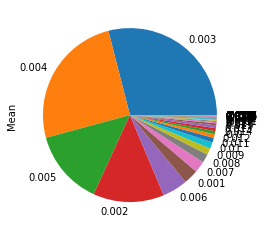

In [45]:
change_df['Mean'].value_counts().plot.pie()

In [46]:
change_df_train = change_df.iloc[:,1:].dropna().drop('Mean',axis=1)

In [47]:
change_df_train.head()

,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
0,0.000155,-0.001760,0.000218,0.000580,0.001616,0.000952,0.001478,0.003642,0.002323,0.004923,...,0.022014,0.019338,0.014122,0.015686,0.015558,0.018399,0.022224,0.024178,0.022871,0.018110
1,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,0.004161,...,0.020906,0.018864,0.017676,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335
2,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,-0.010656,...,0.017665,0.014312,0.011986,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659
3,0.012239,0.008154,0.013035,0.009314,0.009376,0.012232,0.011287,0.011069,0.012919,0.013832,...,0.003479,0.002325,0.003475,0.000684,0.003218,0.000868,0.005741,0.004694,0.011466,0.007525
4,0.003304,0.005237,0.006267,0.004140,0.003375,0.002380,0.009690,0.008719,0.013125,0.009625,...,0.004266,0.004843,0.005561,0.001561,0.005864,0.004972,0.007698,0.003275,0.007969,0.007200


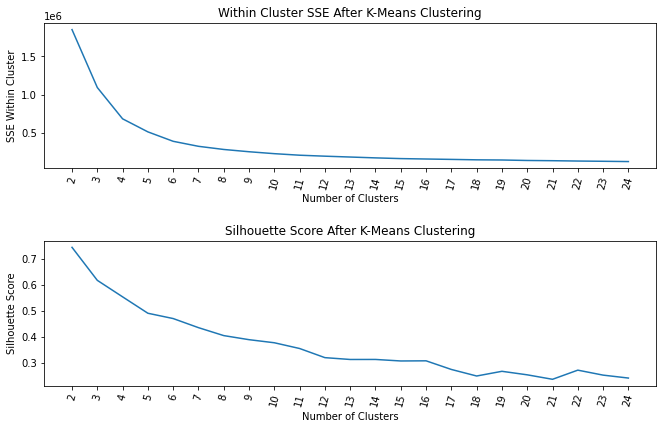

In [48]:
plot_cluster(train_df, max_loop=25)

Optimal Cluster  = 3

### First Iteration

In [49]:
first_trial = apply_cluster(change_df_train, clusters=3)

clustering performance
#############################
silhouette score: 0.06
sse withing cluster: 2594193.480335761


In [50]:
cluster_perf_df = first_trial.groupby('cluster')
cluster_perf_df['cluster'].value_counts()

cluster  cluster
0        0          5872
1        1          3431
2        2          2298
Name: cluster, dtype: int64

In [51]:
colors = ['#DF2020', '#81DF20', '#2095DF']
first_trial['c'] = first_trial.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
first_trial['Y'] = data['ZipCode']
first_trial.head()

,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,cluster,c,Y
0,0.000155,-0.001760,0.000218,0.000580,0.001616,0.000952,0.001478,0.003642,0.002323,0.004923,...,0.015686,0.015558,0.018399,0.022224,0.024178,0.022871,0.018110,0,#DF2020,77449
1,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,0.004161,...,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335,0,#DF2020,77494
2,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,-0.010656,...,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659,0,#DF2020,79936
3,0.012239,0.008154,0.013035,0.009314,0.009376,0.012232,0.011287,0.011069,0.012919,0.013832,...,0.000684,0.003218,0.000868,0.005741,0.004694,0.011466,0.007525,1,#81DF20,11368
4,0.003304,0.005237,0.006267,0.004140,0.003375,0.002380,0.009690,0.008719,0.013125,0.009625,...,0.001561,0.005864,0.004972,0.007698,0.003275,0.007969,0.007200,1,#81DF20,11385


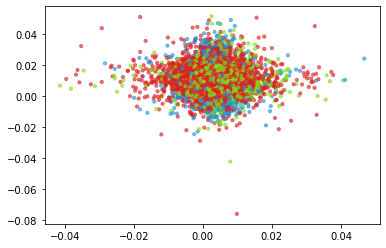

In [52]:
plt.scatter(first_trial['2000-02-29'], first_trial['2022-06-30'],c=first_trial.c, alpha = 0.6, s=10)

### Second Iteration

In [53]:
df3 = first_trial.query("cluster == 0").reset_index(drop=True).drop(['c', 'Y'], axis=1)

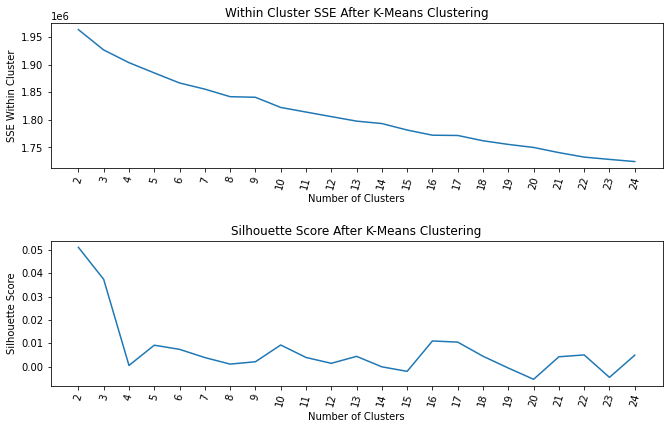

In [54]:
plot_cluster(df3, max_loop=25)

**Optimal Cluster** is 3.

In [55]:
second_trial= apply_cluster(df3, clusters=3)

clustering performance
#############################
silhouette score: 0.04
sse withing cluster: 1926939.3814955656


In [56]:
cluster_perf_df = second_trial.groupby('cluster')
cluster_perf_df['cluster'].value_counts()

cluster  cluster
0        0           831
1        1          3441
2        2          1600
Name: cluster, dtype: int64

In [57]:
colors = ['#FFFFFF', '#3cb44b','#FFFFFF']
second_trial['c'] = second_trial.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
second_trial['Y'] = data['ZipCode']
second_trial.head()

,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,cluster,c,Y
0,0.000155,-0.001760,0.000218,0.000580,0.001616,0.000952,0.001478,0.003642,0.002323,0.004923,...,0.015686,0.015558,0.018399,0.022224,0.024178,0.022871,0.018110,2,#FFFFFF,77449
1,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,0.004161,...,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335,1,#3cb44b,77494
2,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,-0.010656,...,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659,1,#3cb44b,79936
3,-0.000455,-0.002537,-0.000654,-0.000384,0.001663,0.000291,0.001494,0.003563,0.003323,0.005668,...,0.014534,0.014317,0.016092,0.019614,0.020770,0.020210,0.015496,2,#FFFFFF,11368
4,0.002971,0.002067,0.007939,0.010005,0.013683,0.011767,0.010640,0.004872,0.003973,0.001427,...,-0.004601,0.000594,0.001860,0.004760,0.004271,0.004054,0.002986,0,#FFFFFF,11385


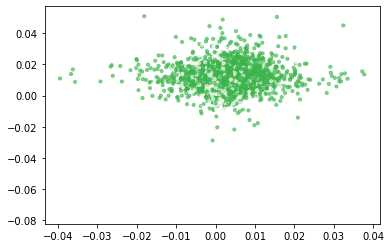

In [58]:
plt.scatter(second_trial['2000-02-29'], second_trial['2022-06-30'],c=second_trial.c, alpha = 0.6, s=10)

After the second iteration we again found two prominent clusters, thus we will dive deeper and perform a third iteration on the more prominent cluster.

### Third Iteration

In [59]:
df4 = second_trial.query("cluster == 1").reset_index(drop=True).drop(['c', 'Y'], axis=1)

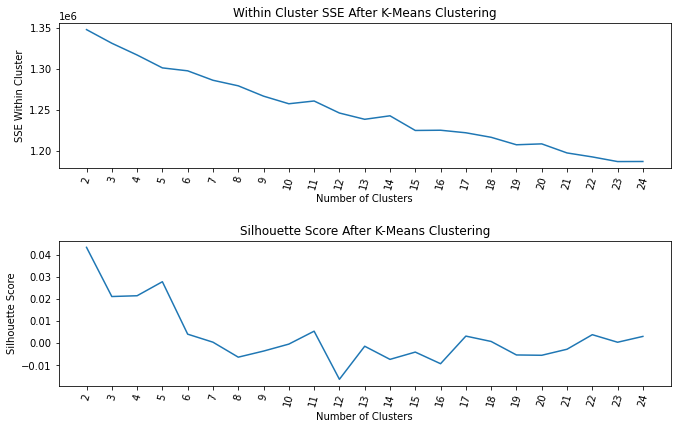

In [60]:
plot_cluster(df4, max_loop=25)

**Optimal Cluster** is 3.

In [61]:
third_trial = apply_cluster(df4, clusters=3)

clustering performance
#############################
silhouette score: 0.02
sse withing cluster: 1331352.0741808838


In [62]:
cluster_perf_df = third_trial.groupby('cluster')
cluster_perf_df['cluster'].value_counts()

cluster  cluster
0        0            24
1        1          1739
2        2          1678
Name: cluster, dtype: int64

In [63]:
colors = ['#e6194b', '#3cb44b', '#2095DF' ]
third_trial['c'] = third_trial.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
third_trial['Y'] = data['ZipCode']
third_trial.head()

,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,cluster,c,Y
0,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,0.004161,...,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335,1,#3cb44b,77449
1,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,-0.010656,...,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659,1,#3cb44b,77494
2,0.002614,0.002833,0.007165,0.002303,0.000117,-0.001340,0.000439,-0.000507,-0.001886,0.000359,...,0.011348,0.011645,0.019207,0.023522,0.026851,0.021204,0.012182,1,#3cb44b,79936
3,0.000402,-0.000010,-0.000627,-0.000637,-0.000893,0.000000,0.000756,0.001609,0.001126,0.001223,...,0.025619,0.026695,0.023237,0.014275,0.014321,0.010969,0.017188,1,#3cb44b,11368
4,0.001167,0.000683,0.004059,0.004786,0.005539,0.001723,-0.002418,-0.009221,-0.012025,-0.012657,...,0.011974,0.013125,0.012965,0.012570,0.019963,0.020994,0.020287,1,#3cb44b,11385


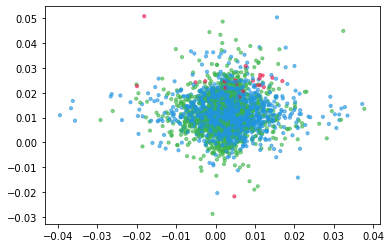

In [64]:
plt.scatter(third_trial['2000-02-29'], third_trial['2022-06-30'],c=third_trial.c, alpha = 0.6, s=10)

In [65]:
cluster_perf_df['cluster'].value_counts()

cluster  cluster
0        0            24
1        1          1739
2        2          1678
Name: cluster, dtype: int64

On performing the third iteration we found that 2 clusters are almost shared divided. Hence, one prominent cluster from iteration 2 itself will become our golden cluster.

In [66]:
change_df_train = change_df.iloc[:,1:].dropna().drop('Mean',axis=1)

In [67]:
change_df_train.head(15)

,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
0,0.000155,-0.001760,0.000218,0.000580,0.001616,0.000952,0.001478,0.003642,0.002323,0.004923,...,0.022014,0.019338,0.014122,0.015686,0.015558,0.018399,0.022224,0.024178,0.022871,0.018110
1,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,0.004161,...,0.020906,0.018864,0.017676,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335
2,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,-0.010656,...,0.017665,0.014312,0.011986,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659
3,0.012239,0.008154,0.013035,0.009314,0.009376,0.012232,0.011287,0.011069,0.012919,0.013832,...,0.003479,0.002325,0.003475,0.000684,0.003218,0.000868,0.005741,0.004694,0.011466,0.007525
4,0.003304,0.005237,0.006267,0.004140,0.003375,0.002380,0.009690,0.008719,0.013125,0.009625,...,0.004266,0.004843,0.005561,0.001561,0.005864,0.004972,0.007698,0.003275,0.007969,0.007200
5,0.004065,0.007301,0.008621,0.008146,0.006947,0.010199,0.009092,0.006706,0.002952,0.005427,...,0.000129,-0.000998,0.006332,0.004925,0.006764,0.012118,0.022659,0.023166,0.013056,-0.000477
6,0.000172,0.002576,0.005744,0.007634,0.008837,0.008898,0.009739,0.008684,0.008567,0.011003,...,0.011908,0.011338,0.012440,0.010335,0.011718,0.007902,0.008666,0.008692,0.013534,0.008020
7,-0.000455,-0.002537,-0.000654,-0.000384,0.001663,0.000291,0.001494,0.003563,0.003323,0.005668,...,0.022354,0.019049,0.012789,0.014534,0.014317,0.016092,0.019614,0.020770,0.020210,0.015496
8,0.001844,0.005205,0.009410,0.011552,0.012958,0.014032,0.014335,0.011650,0.009177,0.009176,...,0.004909,0.001131,0.008440,0.009414,0.006925,0.011368,0.014612,0.019217,0.015489,0.001976
9,0.000393,0.003087,0.005941,0.007882,0.008940,0.009577,0.010100,0.007270,0.005435,0.005689,...,0.011826,0.006542,0.006947,0.008256,0.007650,0.012605,0.020293,0.025076,0.021610,0.004941


In [68]:
change_df_train.head

<bound method NDFrame.head of        2000-02-29  2000-03-31  2000-04-30  2000-05-31  2000-06-30  2000-07-31  \
0        0.000155   -0.001760    0.000218    0.000580    0.001616    0.000952   
1        0.001529    0.001612    0.004157   -0.000874   -0.001428   -0.006510   
2        0.000700    0.000573    0.000206    0.000641    0.000034   -0.000034   
3        0.012239    0.008154    0.013035    0.009314    0.009376    0.012232   
4        0.003304    0.005237    0.006267    0.004140    0.003375    0.002380   
...           ...         ...         ...         ...         ...         ...   
23355   -0.001627    0.007682    0.010366   -0.000390   -0.007743   -0.008337   
23363    0.003876    0.002807    0.003842    0.004487    0.003153    0.006286   
23382    0.013627    0.010596    0.012444    0.005137   -0.000082    0.001725   
23388    0.003167   -0.015583   -0.011974   -0.008901    0.007337    0.006159   
23394    0.004559    0.003378    0.007430    0.007378    0.011328    0.010604  

# Agglomerative Clustering

## Importing Libraries

In [69]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn import metrics

## Applying Agglomerative Clustering and plot

Agglomerative Clustering Using Ward Method
[2 2 2 ... 2 2 1]


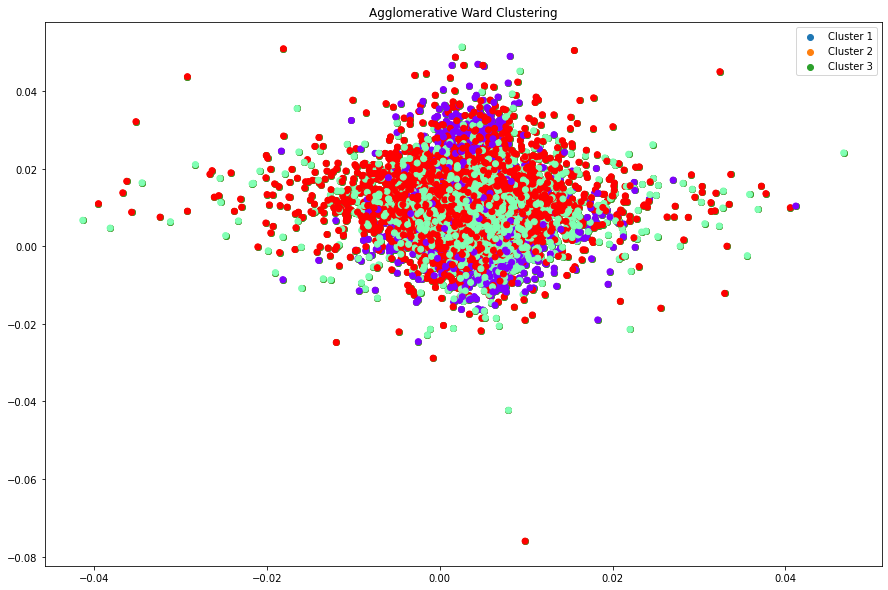

In [70]:
plt.figure(figsize=(15,10))
data1 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agglo_pred = data1.fit_predict(change_df_train)
cluster_labels = data1.labels_
print('Agglomerative Clustering Using Ward Method')
print(agglo_pred)
plt.scatter(change_df_train['2000-02-29'], change_df_train['2022-06-30'], cmap = 'rainbow', label = 'Cluster 1')
plt.scatter(change_df_train['2000-02-29'], change_df_train['2022-06-30'], cmap = 'rainbow', label = 'Cluster 2')
plt.scatter(change_df_train['2000-02-29'], change_df_train['2022-06-30'], cmap = 'rainbow', label = 'Cluster 3')
plt.scatter(change_df_train['2000-02-29'], change_df_train['2022-06-30'], c=data1.labels_, cmap='rainbow')
plt.title('Agglomerative Ward Clustering')
# plt.xticks([i for i in range(0, 5)], rotation=360)
# plt.yticks([i for i in range(0, 5)], rotation=360)
plt.legend()
plt.show()

## Silhouette Score

In [71]:
score = metrics.silhouette_score(change_df_train, cluster_labels, metric='euclidean', random_state=10)
print("silhouette score: " + str(score.round(2)))

silhouette score: 0.07


# DBSCAN

## Importing Libraries

In [72]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## Scaling 

In [73]:
Sc = StandardScaler()
X = Sc.fit_transform(change_df_train)


## PCA for dimensionality reduction

[[-2.79651172  3.74768798]
 [-5.55789288  0.71846065]
 [-6.31531837  1.82033604]
 ...
 [-1.03323647 -7.4983227 ]
 [-7.41180366  1.35923227]
 [-1.70643266 -5.1129772 ]]


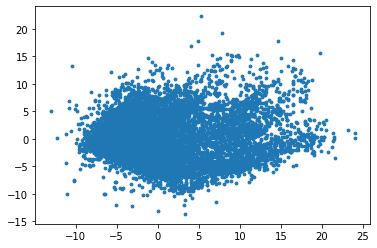

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vis = pca.fit_transform(X)
print(vis)
plt.scatter(vis[:,0], vis[:, 1], s=8)

## Applying DBSCAN

Silhouette Coefficient: -0.059


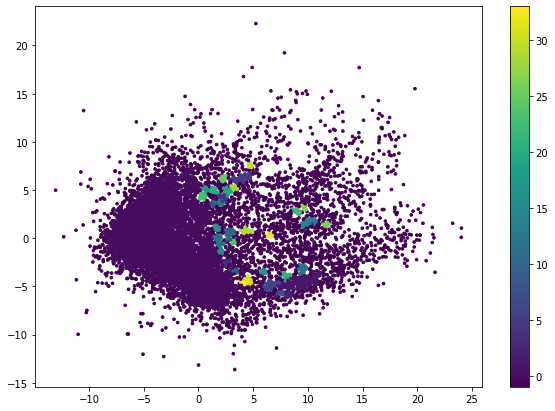

In [75]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(vis)
plt.figure(figsize=(10,7))
dbsc_labels=db.labels_
plt.scatter(vis[:,0], vis[:, 1], s=7, c=dbsc_labels)
plt.colorbar()
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, dbsc_labels))

In [76]:
pd.Series(db.labels_).value_counts()

 0     7738
-1     3067
 1      173
 5       58
 6       49
 14      38
 10      35
 11      31
 12      30
 4       23
 21      22
 29      21
 19      20
 2       19
 3       18
 23      18
 22      17
 18      17
 20      17
 31      15
 16      15
 25      15
 7       14
 15      13
 8       12
 28      12
 13      11
 17      11
 24      11
 27      11
 32      11
 26      10
 9       10
 30      10
 33       9
dtype: int64

# Spectral Clustering

## Importing Library

In [ ]:
from sklearn.cluster import SpectralClustering

In [98]:
def plot_cluster_spectral(df, max_loop=50):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:].values    
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)

    silhouette_score = {}

    for k in range(2, max_loop):
        cluster_labels = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=10, affinity='rbf').fit_predict(X_rb)
        silhouette_score[k] = metrics.silhouette_score(X_rb, cluster_labels, random_state=10)

    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After Spectral Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

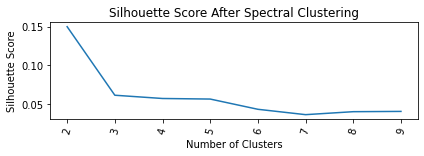

In [99]:
plot_cluster_spectral(change_df_train, 10)

**Comparing the Silhoeutte Scores, it can be found that Agglomerative Clustering is best suited for this modelling.**

# Applying Agglomerative clustering with fractal distance 

In [100]:
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=c3c81ea4da72cff6f3eeec0bef6427ae72fee05cec525949b8b620b5bf417b93
  Stored in directory: /root/.cache/pip/wheels/dc/25/8b/072b221a5cff4f04e7999d39ca1b6cb5dad702cc3e1da951d4
Successfully built pyclustering


In [101]:
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering

In [102]:
def fractal_distance(p1, p2): 
  x1, y1, x2, y2 = p1[0],p1[1], p2[0], p2[1]
  num_divisions = 10
  # Create a grid with num_divisions x num_divisions boxes
  x = np.linspace(min(x1, x2), max(x1, x2), num_divisions + 1) 
  y = np.linspace(min(y1, y2), max(y1, y2), num_divisions + 1) 
  grid = np.zeros((num_divisions, num_divisions))
  
  # Place a point at each of the two endpoints
  x1_idx = np.argmin(np.abs(x - x1)) - 1
  y1_idx = np.argmin(np.abs(y - y1)) - 1
  grid[y1_idx, x1_idx] = 1
  x2_idx = np.argmin(np.abs(x - x2)) - 1
  y2_idx = np.argmin(np.abs(y - y2)) - 1
  grid[y2_idx, x2_idx] = 1

  # Count the number of boxes that contain at least one point 
  num_boxes_with_points = 0
  for i in range(num_divisions):
    for j in range(num_divisions):
      if np.sum(grid[i:i+2, j:j+2]) > 0:
        num_boxes_with_points += 1
  
  # Calculate the fractal dimension and use it to estimate the length of the path
  fractal_dim = np.log(num_boxes_with_points) / np.log(2)
  fractal_length = (2 ** fractal_dim) * ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
  return fractal_length

In [107]:


def plot_cluster_agglo(df, max_loop=50):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:].values    
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)

    def sim_affinity(X):
      return metrics.pairwise_distances(X, metric=fractal_distance)

    silhouette_score = {}
    
    for k in range(2, max_loop):
        instance = AgglomerativeClustering(n_clusters=k, affinity=sim_affinity, linkage='average')
        instance.fit_predict(X_rb)
        cluster_labels = instance.labels_
        silhouette_score[k] = metrics.silhouette_score(X_rb, cluster_labels, random_state=10)

    _ = plt.figure(figsize=(10,6))
    
    ax1 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After Agglomerative Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)


In [ ]:
change_df_train = change_df.iloc[:,1:].dropna().drop('Mean',axis=1)

In [ ]:
plot_cluster_agglo(change_df_train, 10)

In [105]:
def apply_cluster_agglo(df, clusters=2):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    def sim_affinity(X):
      return metrics.pairwise_distances(X, metric=fractal_distance)

    instance = AgglomerativeClustering(n_clusters=clusters, affinity=sim_affinity, linkage='average')
    instance.fit_predict(X_rb)
    score = metrics.silhouette_score(X_rb, instance.labels_, random_state=10)
    df['cluster'] = instance.labels_
    # sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("######################")
    print("silhouette score: " + str(score.round(2)))
    
    return df

# Fractal Clustering on Best performing algorithm

In [79]:
change_df_train1= change_df.iloc[:,1:].dropna().drop('Mean',axis=1)
change_df_train1.head()

,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
0,0.000155,-0.001760,0.000218,0.000580,0.001616,0.000952,0.001478,0.003642,0.002323,0.004923,...,0.022014,0.019338,0.014122,0.015686,0.015558,0.018399,0.022224,0.024178,0.022871,0.018110
1,0.001529,0.001612,0.004157,-0.000874,-0.001428,-0.006510,-0.001213,-0.003470,0.002664,0.004161,...,0.020906,0.018864,0.017676,0.014664,0.014222,0.020819,0.025000,0.029524,0.023412,0.014335
2,0.000700,0.000573,0.000206,0.000641,0.000034,-0.000034,-0.000389,-0.006230,-0.007237,-0.010656,...,0.017665,0.014312,0.011986,0.010026,0.011815,0.011689,0.012228,0.018585,0.019823,0.018659
3,0.012239,0.008154,0.013035,0.009314,0.009376,0.012232,0.011287,0.011069,0.012919,0.013832,...,0.003479,0.002325,0.003475,0.000684,0.003218,0.000868,0.005741,0.004694,0.011466,0.007525
4,0.003304,0.005237,0.006267,0.004140,0.003375,0.002380,0.009690,0.008719,0.013125,0.009625,...,0.004266,0.004843,0.005561,0.001561,0.005864,0.004972,0.007698,0.003275,0.007969,0.007200


In [ ]:
plot_cluster_agglo(change_df_train1, 25)

In [ ]:
first_trial_agglo = apply_cluster_agglo(change_df_train1, clusters=3)

In [ ]:
cluster_df_agglo = first_trial_agglo.groupby('cluster')
cluster_df_agglo['cluster'].value_counts()

In [ ]:
colors = ['#DF2020', '#81DF20', '#2095DF']
first_trial_agglo['c'] = first_trial_agglo.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
first_trial_agglo['Y'] = data['ZipCode']
first_trial_agglo.head()

In [ ]:
plt.scatter(first_trial_agglo['2000-02-29'], first_trial_agglo['2022-06-30'],c=first_trial_agglo.c, alpha = 0.6, s=10)

In [ ]:
df5 = first_trial_agglo.query("cluster == 2").reset_index(drop=True).drop(['c', 'Y'], axis=1)

In [ ]:
df5.head()

In [ ]:
plot_cluster_agglo(df5,10)

In [ ]:
second_trial_agglo= apply_cluster_agglo(df5, clusters=3)

In [ ]:
cluster_df_agglo2 = second_trial_agglo.groupby('cluster')
cluster_df_agglo2['cluster'].value_counts()

In [ ]:
colors = ['#FFFFFF', '#3cb44b','#FFFFFF']
second_trial_agglo['c'] = second_trial_agglo.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
second_trial_agglo['Y'] = data['ZipCode']
second_trial_agglo.head()

In [ ]:
plt.scatter(second_trial_agglo['2000-02-29'], second_trial_agglo['2022-06-30'],c=second_trial_agglo.c, alpha = 0.6, s=10)